In [2]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot
import os
import string
from pymorphy2 import MorphAnalyzer
from razdel import tokenize
from nltk.corpus import stopwords
from tqdm import tqdm

In [3]:
morph = MorphAnalyzer()
stop = set(stopwords.words('russian'))

def my_preprocess(text: str):
    text = str(text)
    text = text.replace("\n", " ").replace('/', ' ')
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokenized_text = list(tokenize(text))
    lemm = [morph.parse(i.text)[0].normal_form for i in tokenized_text]
    words = [i for i in lemm if i not in stop]
    return " ".join(words)


### Load and normalize train texts

In [5]:
path_to_folder_neg = "aclimdb/train/neg/"
path_to_folder_pos = "aclimdb/train/pos/"
texts = [] 
for file in os.listdir(path_to_folder_neg): 
    if file.endswith('.txt'): 
        with open(path_to_folder_neg + file, "r") as f:
            texts.append((file, f.read(), 0))

for file in os.listdir(path_to_folder_pos): 
    if file.endswith('.txt'): 
        with open(path_to_folder_pos + file, "r") as f:
            texts.append((file, f.read(), 1))

In [6]:
data_train = pd.DataFrame(texts, columns=['filename', 'text', 'posLabel'])
buf_arr = []

for i in tqdm(data_train.text.values):
    buf_arr.append(my_preprocess(i))

data_train['normalizedText'] = buf_arr
data_train.head()

100%|██████████| 25000/25000 [02:22<00:00, 175.91it/s]


,filename,text,posLabel,normalizedText
0,1821_4.txt,Working with one of the best Shakespeare sourc...,0,working with one of the best shakespeare sourc...
1,10402_1.txt,"Well...tremors I, the original started off in ...",0,welltremors i the original started off in 1990...
2,1062_4.txt,Ouch! This one was a bit painful to sit throug...,0,ouch this one was a bit painful to sit through...
3,9056_1.txt,"I've seen some crappy movies in my life, but t...",0,ive seen some crappy movies in my life but thi...
4,5392_3.txt,"""Carriers"" follows the exploits of two guys an...",0,carriers follows the exploits of two guys and ...


### Load and normalized test texts

In [7]:
path_to_folder_neg = "aclimdb/test/neg/"
path_to_folder_pos = "aclimdb/test/pos/"
texts = [] 
for file in os.listdir(path_to_folder_neg): 
    if file.endswith('.txt'): 
        with open(path_to_folder_neg + file, "r") as f:
            texts.append((file, f.read(), 0))

for file in os.listdir(path_to_folder_pos): 
    if file.endswith('.txt'): 
        with open(path_to_folder_pos + file, "r") as f:
            texts.append((file, f.read(), 1))

In [8]:
data_test = pd.DataFrame(texts, columns=['filename', 'text', 'posLabel'])
buf_arr = []

for i in tqdm(data_test.text.values):
    buf_arr.append(my_preprocess(i))

data_test['normalizedText'] = buf_arr
data_test.head()

100%|██████████| 25000/25000 [02:19<00:00, 178.64it/s]


,filename,text,posLabel,normalizedText
0,1821_4.txt,Alan Rickman & Emma Thompson give good perform...,0,alan rickman emma thompson give good performan...
1,9487_1.txt,I have seen this movie and I did not care for ...,0,i have seen this movie and i did not care for ...
2,4604_4.txt,"In Los Angeles, the alcoholic and lazy Hank Ch...",0,in los angeles the alcoholic and lazy hank chi...
3,2828_2.txt,"This film is bundled along with ""Gli fumavano ...",0,this film is bundled along with gli fumavano l...
4,10890_1.txt,I only comment on really very good films and o...,0,i only comment on really very good films and o...


## Ваша задача в sklearn, используя один из алгоритмов, рассмотренных на паре, построить и обучить классификатор, посчитать метрики качества, построить ROC кривую и посчитайте величину ROC AUC.

#### Create CountVectorizer and fit MultinominalNB

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
#Learn the vocabulary dictionary and return term-document matrix.
X_train_counts = count_vect.fit_transform(data_train.normalizedText)
X_test = count_vect.transform(data_test.normalizedText)
X_train_counts.shape

(25000, 116551)

In [10]:
clf = MultinomialNB().fit(X_train_counts, data_train.posLabel)

y_true = np.array(data_test.posLabel.values)
y_pred = np.array(clf.predict(X_test))
y_pred_proba = np.array([1 - i[0] for i in clf.predict_proba(X_test)])

In [11]:
y_pred_proba.shape

(25000,)

In [12]:
np.array(y_pred).shape

(25000,)

ROC AUC value:  0.81444


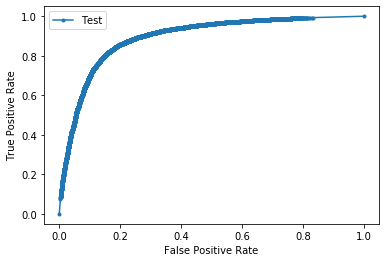

In [13]:
fpr, tpr, thrhld = roc_curve(y_true, y_pred_proba)
print("ROC AUC value: ", roc_auc_score(y_true, y_pred))
pyplot.plot(fpr, tpr, marker='.', label='Test')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [14]:
prec, rec, fs, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")

print("Precision:", prec)
print("Recall:", rec)
print("F1 score:", fs)
print("ROC AUC value:", roc_auc_score(y_true, y_pred))

Precision: 0.8594421582075903
Recall: 0.75184
F1 score: 0.8020482184766374
ROC AUC value: 0.81444


## Используя предсказания вероятностей класса, найдите 15 самых негативных и самых позитивных рецензий по мнению модели.

In [15]:
y_pred_proba = clf.predict_proba(X_test)

In [16]:
y_pred_proba = [1 - i[0] for i in y_pred_proba]

In [17]:
indices_max = np.array(y_pred_proba).argsort()[-15:][::-1]
indices_min = np.array(y_pred_proba).argsort()[:15]

indices_max

array([17609, 17303, 17390, 17383, 23528, 17357, 17347, 17340, 17331,
       17328, 17326, 17286, 17169, 23561, 17266])

#### 15 самых позитивных рецензий

In [18]:
data_test.iloc[indices_max].text.values

array(['Ida Lupino is trapped in her own home by crazy Robert Ryan in "Beware, My Lovely," a 1952 film from RKO. Lupino and Ryan did three films together and worked well as a team, both being consummate professionals and strong performers. In this film, based on a Broadway play called "The Man," Lupino is a World War I widow who rents out a room in her home. She\'s very active and well-liked in her community and though her husband has been dead for two years, she\'s not ready to move on. The man who rents her room goes on vacation, and Lupino hires Robert Ryan to help her with some heavy-duty cleaning in the house. He\'s friendly enough to start, but later terrorizes her, locking her in the house, and not allowing her to answer the phone or the door, as he grows violent and more out of touch with reality.<br /><br />The character played by Ryan is shown in the beginning of the movie running away when he discovers a dead body in another house he\'s working in. It isn\'t clear whether or

#### 15 самых негативных рецензий

In [19]:
data_test.iloc[indices_min].text.values

array(["I'd heard a lot of bad things about this film before seeing it, but thought all the negative comments were probably down to the film's low budget and poor acting - both of which I can deal with when it comes to zombie films. However, what I didn't count on is this film being really, really boring; if there's one thing you can count on from low budget zombies, its gore and entertainment - but unfortunately, this film has neither. I'm quite surprised, because the previous two horror films I've seen from director Bob Clark - Deathdream and Black Christmas - were both highly inventive and entertaining films, but Children Shouldn't Play with Dead Things just doesn't cut it. The plot line follows a group of young adults that travel to a burial island in order to mess about with rituals to bring the dead back to life. However, they soon learn that playing with things they don't understand is a really stupid idea when their rituals actually bring the dead back to life and the corpses o

## Написать свои функции, которые бы считали tp, fp, tn, fn, и возвращали точность, полноту и ф-меру и применить их к результатам, полученным вашими классификаторами (если все сделано правильно, то результаты должны совпадать с полученными  sklearn метриками).

In [20]:
def get_tp(y_true, y_pred):
    return sum([1 for ind, val in enumerate(y_true) if y_pred[ind] == 1 and val == 1])

def get_tn(y_true, y_pred):
    return sum([1 for ind, val in enumerate(y_true) if y_pred[ind] == 0 and val == 0])

def get_fn(y_true, y_pred):
    return sum([1 for ind, val in enumerate(y_true) if y_pred[ind] == 0 and val == 1])

def get_fp(y_true, y_pred):
    return sum([1 for ind, val in enumerate(y_true) if y_pred[ind] == 1 and val == 0])

def get_precision(y_true, y_pred):
    return get_tp(y_true, y_pred) / (get_tp(y_true, y_pred) + get_fp(y_true, y_pred))

def get_recall(y_true, y_pred):
    return get_tp(y_true, y_pred) / (get_tp(y_true, y_pred) + get_fn(y_true, y_pred))

def get_f_measure(y_true, y_pred, beta=1):
    prec = get_precision(y_true, y_pred)
    rec = get_recall(y_true, y_pred)
    return (1 + beta**2) * (prec * rec) / (beta**2 * (prec + rec))

In [21]:
precision_recall_fscore_support(y_true, y_pred, average="binary")

(0.8594421582075903, 0.75184, 0.8020482184766374, None)

In [22]:
get_precision(y_true, y_pred)

0.8594421582075903

In [23]:
get_recall(y_true, y_pred)

0.75184

In [24]:
get_f_measure(y_true, y_pred)

0.8020482184766374